In [1]:
import paho.mqtt.client as mqtt
import threading
import os
import re
# import motionlocalizer.settings
import json
# import requests
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import xml.etree.ElementTree
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import time as pythonTimer

simworldname = 'simulationWorld_library2.xml'
groundtruth = 'rssi4.csv'

my_map = [(0.0, 0.0), (0.0, 54), (67, 54), (67, 0.0)]
grid_map = np.zeros((int(my_map[2][0]) * 1, int(my_map[2][1]) * 1))
distances = []

oracle = {}
oracle['time'] = []
oracle['location'] = []

analyzer = {}
analyzer['time'] = []
analyzer['gridmap'] = []


def on_connect(client, userdata, flags, rc):
    # print("user "+str(userdata))
    # print("client "+str(client))
    # print("Connected with result code "+str(rc))
    client.subscribe("/casiSimulator/#")

def on_message(client, userdata, msg):
    global oracle
    result = msg.topic+" "+str(msg.payload)
    # print(result)

    # Oracle's Interest
    if (result.split('/')[1] == "action_reeding"):
        str1 = re.search(result.split('[')[0] +'(.*)]', result)
        point = str1.group(1).replace('[', "").split(',')

        x = float(point[0])
        y = float(point[1])
        loc = [x, y]
        timetoadd = int((result.split(' ')[1]).split(',')[0])

        if loc not in oracle['location'] and timetoadd not in oracle['time']:
            oracle['location'].append([x, y])
            oracle['time'].append(timetoadd)

    # Inference's Interest
    if (result.split('/')[1] == "sensor_readings"):
        event = ParseResult(result)
        run_localization(event)


def on_publish(client, userdata, result):
    # print("Data published :" + str(client) + " " + str(userdata) + str(result) + "\n")
    ParseResult(result)
    pass

def on_subscribed(mosq, obj, mid, granted_qos):
    print("Subscribed mid: " + str(mid) + ", qos: " + str(granted_qos))
    
def start_localizing(event):
    global analyzer
    global oracle
    global grid_map
    run_localization(event)

def run_localization(event):
    global analyzer
    global oracle
    global grid_map
    # print("run_localization")
    Localizer(pythonTimer.time()).run(event)

def ParseResult(result):            
    event = Event()
    event.sensor = (result.split('/')[3]).split(' ')[0]
    event.data = ((result.split('/')[3]).split(' ')[1]).split(',')[2]
    event.hash = "|hash|"
    event.source = (result.split('/')[3]).split(' ')[0]
    event.timestamp = ((result.split('/')[3]).split(' ')[1]).split(',')[0]
    return event

In [2]:
# Copyright (c) 2017 The Governors of the University of Alberta

class Sensor:
    sensor_type = ""
    sensor_id = ""
    x = float()
    y = float()
    z = float()
    sensing_area = ""

    def __str__(self):
        return 'type: %s,\n id: %s,\n x: %s,\n y: %s\n'%(self.sensor_type, self.sensor_id, self.x, self.y)

    def Initialize(self, element):
        self.x = (str(element.find('point').find('xcoord').text))
        self.y = (str(element.find('point').find('ycoord').text))
        self.sensor_id = (str(element.find('id').text))
        self.sensor_type = (str(element.find('type').text))
        
        if self.sensor_type == 'RFID_Reader':
            self.sensing_area = (str(element.find('arcSize').text))
            
        elif self.sensor_type == 'MotionSensorBinary':
            self.sensing_area = (str(element.find('radius').text))
            
        elif self.sensor_type == 'MotionSensorAnalog':
            self.sensing_area = (str(element.find('radius').text))
            
        elif self.sensor_type == 'PressureSensorAnalog':
            self.sensing_area = (str(element.find('radius').text))
        
            
        return 0

class Event:
    source = ""
    timestamp = float()
    sensor = Sensor.sensor_id
    data = int()
    hash = ""

    def __str__(self):
        return 'time: %s --> sensor: <%s>", data: %s' % (
        str(self.timestamp), str(self.sensor), str(self.data))


class GridMap:
    map = ""

In [3]:
##############################
### PARSE SIMULATION WORLD ###
##############################

root = xml.etree.ElementTree.parse(simworldname).getroot()


print(grid_map)

sensors_list = []

for element in root:
    if(element.tag == 'sensors'):
        for sensor in element:
            # print(type(sensor))
            this_sensor = Sensor()
            this_sensor.Initialize(sensor)
            
            
            print(type(this_sensor))
            
            sensors_list.append(this_sensor)
            # print(this_sensor.sensor_type + " " + this_sensor.x + " " + this_sensor.y)
            # sensors_list.append(sensor)
            print(sensors_list[len(sensors_list) - 1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<type 'instance'>
type: MotionSensorBinary,
 id: sensor1,
 x: 60,
 y: 36

<type 'instance'>
type: MotionSensorBinary,
 id: sensor2,
 x: 21,
 y: 39

<type 'instance'>
type: MotionSensorBinary,
 id: sensor3,
 x: 60,
 y: 27

<type 'instance'>
type: MotionSensorBinary,
 id: sensor4,
 x: 24,
 y: 3

<type 'instance'>
type: MotionSensorBinary,
 id: sensor5,
 x: 21,
 y: 45

<type 'instance'>
type: MotionSensorBinary,
 id: sensor6,
 x: 57,
 y: 42

<type 'instance'>
type: MotionSensorBinary,
 id: sensor7,
 x: 24,
 y: 6

<type 'instance'>
type: MotionSensorBinary,
 id: sensor8,
 x: 54,
 y: 21

<type 'instance'>
type: MotionSensorBinary,
 id: sensor9,
 x: 9,
 y: 36

<type 'instance'>
type: MotionSensorBinary,
 id: sensor10,
 x: 3,
 y: 30

<type 'instance'>
type: MotionSensorBinary,
 id: sensor11,
 x: 42,
 y: 48

<type 'instance'>
type: MotionSe

In [4]:
##########################
### LOCALIZATION CLASS ###
##########################

# Copyright (c) 2017 The Governors of the University of Alberta

class Localizer(threading.Thread):
    to_be_localized_queue = []
    localizer_lock = threading.Lock()
    this_grid_map = []
    
    
    def __init__(self, time):
        self.time = time

    def run(self, event):
        global grid_map
        global analyzer
        global oracle
        global distances
        # print("Run")
        Localizer.to_be_localized_queue.append(self.time)
        with Localizer.localizer_lock:
            while len(Localizer.to_be_localized_queue) > 0:
                timestamp = Localizer.to_be_localized_queue[0]
                Localizer.to_be_localized_queue = Localizer.to_be_localized_queue[1:]
                self.localize(timestamp, event)
    
    def localizer_confidence(self):
        return 0.9

    def get_event_period(self):
        return 1.0
    
    def localize(self, time, event):
        global grid_map
        global analyzer
        global oracle
        global distances
        # print("Localize")
        fired_sensors = []
        fired_sensors = self.FindFiredSensor(event)
        if len(fired_sensors) == 0:
            return
        
        counter = 0
        try:
            m1 = np.min(grid_map[np.nonzero(grid_map)])
            M1 = np.max(grid_map[np.nonzero(grid_map)])

            # print("Value in try:", m1)
            # print("Value in try:", M1)
            
        except:
            print("start!")
            
        for i in range(len(grid_map[:,1])):
            for j in range(len(grid_map[1,:])):
                for sensor in fired_sensors:
                    my_sensor = Sensor()
                    my_sensor = sensor
                    r = my_sensor.sensing_area
                    x = my_sensor.x
                    y = my_sensor.y

                    # circ = Circle((int(int(x)/10), int(int(y)/10)), int(int(r)/10))
                    circ = Circle((int(int(x)), int(int(y))), int(int(r)))
                    
                    if (circ.contains_point([i, j])):
                        grid_map[i][j] += 1

        # print("s1")
        sumofpoints = sum(sum(grid_map))/4
        # print("SUm of points is: " + str(sumofpoints))
        
        if (sumofpoints == 0):
            print("nooooooooooooooooooo")
        else:
            grid_map = np.true_divide(grid_map, sumofpoints)
          
        analyzer['time'].append(event.timestamp)
        analyzer['gridmap'].append(grid_map)
        
        plt.imshow(zip(*grid_map), cmap='hot', interpolation='nearest')
        plt.show()
        
        
        dist = self.ReportError(event.timestamp, grid_map)
        distances.append(dist)
        
        
        print(dist)
        
        # print("the max in final stage is: " + str(np.max(grid_map)))
        
        #grid_map = self.NormalizeGrid()
        # m = np.min(grid_map)
        # M = np.max(grid_map)
        
        # m1 = np.min(grid_map[np.nonzero(grid_map)])
        # M1 = np.max(grid_map[np.nonzero(grid_map)])
        
        # print("Value:", m1)
        # print("Value:", M1)
        
        # for i in range(len(grid_map[:,1])):
        #     for j in range(len(grid_map[1,:])):
        #         grid_map[i][j] = (grid_map[i][j] - m) / (M - m)
                
    def ReportError(self, time, recent_grid):
        global oracle
        
        inferred_location = self.AskLocationFromLocalizer(recent_grid)
        real_location = self.AskLocationFromOracle(time)
        
        print(inferred_location)
        print(real_location)
        
        return np.linalg.norm(inferred_location - real_location)
        
        
    def AskLocationFromLocalizer(self, recent_grid):
        return np.mean(zip(*np.where(recent_grid == np.max(recent_grid))), axis = 0)
    
    def AskLocationFromOracle(self, time):
        point = np.mean(np.asarray(oracle['location'])[np.where(np.asarray(oracle['time']) == int(time))], axis = 0)
        # point[0] = point[0]/10
        # point[1] = point[1]/10
        
        point[0] = point[0]
        point[1] = point[1]
        
        return point
    
    def FindFiredSensor(self, event):
        fired_sensors2 = []
        firedsensor = event.sensor
        for i in range(len(sensors_list)):
            current_sensor = Sensor()
            current_sensor = sensors_list[i]
            if current_sensor.sensor_id == firedsensor:
                fired_sensors2.append(current_sensor)
        
        return fired_sensors2
    
    def extract_fired_sensors(self, start, end):
        sensors = sensors_list
        fired_sensors = []
        for s in sensors:
            if Event.objects.filter(timestamp__gt=start, timestamp__lt=end, sensor=s).exists():
                fired_sensors.append(s)
                continue
            if Event.objects.filter(sensor=s).exists():
                last_event = Event.objects.filter(sensor=s).latest(field_name='timestamp')
                if int(last_event.data) == 1:
                    # print('latest is 1')
                    # print(s)
                    fired_sensors.append(s)

        return fired_sensors


In [5]:
#temporary:
# my_map = [(0.0, 0.0), (0.0, 5.7), (7.05, 5.7), (7.05, 0.0)]
# grid_map = np.zeros((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))



# print(np.max(grid_map))
# print("first input")
# result = "casiSimulator/sensor_readings/MotionSensorBinary/MotionSensorBinary-288.3-495.0 1538687434000,MotionSensorBinary,MotionSensorBinary-288.3-495.0,TRUE,TRUE1"
# event = ParseResult(result)
# start_localizing()
# print(np.max(grid_map[np.nonzero(grid_map)]))
# print(np.min(grid_map[np.nonzero(grid_map)]))
# plt.imshow(grid_map, cmap='hot', interpolation='nearest')
# plt.show()

# print('---------------------------')

# print(np.max(grid_map))
# print("second input")
# result1 = "casiSimulator/sensor_readings/MotionSensorBinary/MotionSensorBinary-511.6-343.6 1538687449000,MotionSensorBinary,MotionSensorBinary-511.6-343.6,TRUE,TRUE1"
# event = ParseResult(result1)
# start_localizing()
# print(np.max(grid_map[np.nonzero(grid_map)]))
# print(np.min(grid_map[np.nonzero(grid_map)]))
# plt.imshow(grid_map, cmap='hot', interpolation='nearest')
# plt.show()



In [6]:
port = 1883
host = "localhost"
keepalive = 60
broker_topic = "#"  #All topics have to be read



client = mqtt.Client()
client.on_connect = on_connect
client.on_message = on_message
client.on_publish = on_publish
client.on_subscribed = on_subscribed

client.connect(host, port, 60)
client.subscribe(broker_topic, 0)

client.loop_start()


please start simulation in casi now.
start!


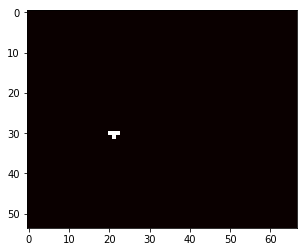

[21.   30.25]
[20. 30.]
1.0307764064044151


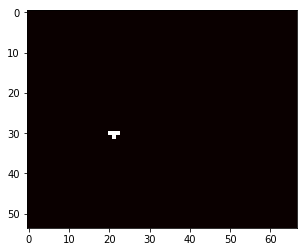

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[21.   30.25]
[nan nan]
nan


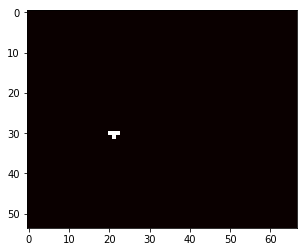

[21.   30.25]
[21. 29.]
1.25


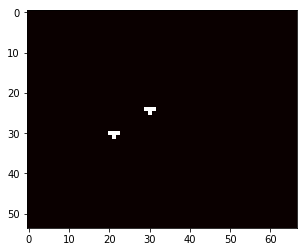

[25.5  27.25]
[29. 23.]
5.50567888638631


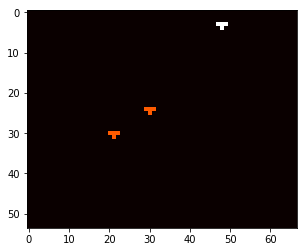

[48.    3.25]
[48.  3.]
0.25


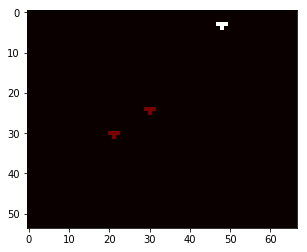

[48.    3.25]
[nan nan]
nan


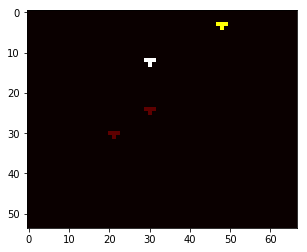

[30.   12.25]
[30. 12.]
0.25


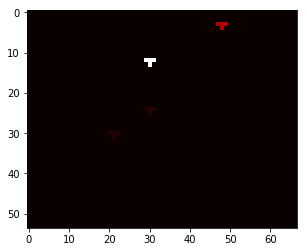

[30.   12.25]
[30. 12.]
0.25


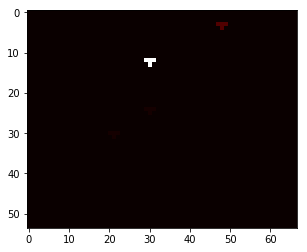

[30.   12.25]
[nan nan]
nan


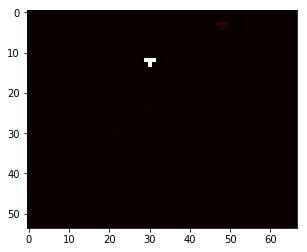

[30.   12.25]
[nan nan]
nan


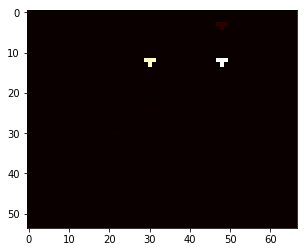

[48.   12.25]
[47. 12.]
1.0307764064044151


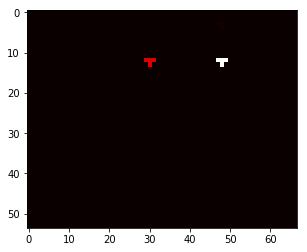

[48.   12.25]
[48. 12.]
0.25


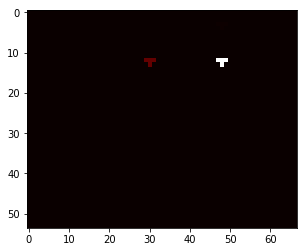

[48.   12.25]
[nan nan]
nan


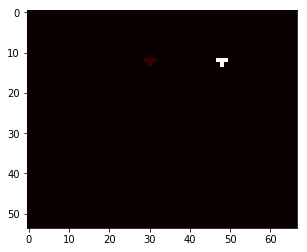

[48.   12.25]
[nan nan]
nan


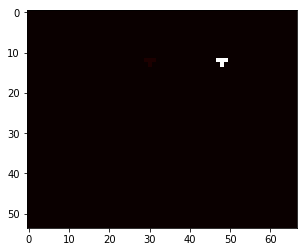

[48.   12.25]
[nan nan]
nan


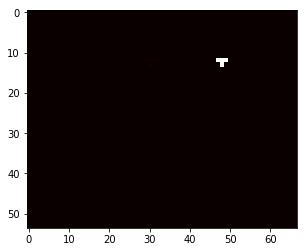

[48.   12.25]
[nan nan]
nan


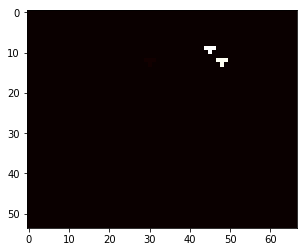

[45.    9.25]
[45.  9.]
0.25


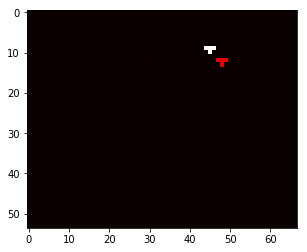

[45.    9.25]
[44.  9.]
1.0307764064044151


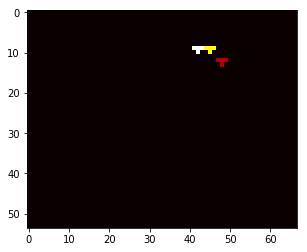

[42.    9.25]
[42.  9.]
0.25


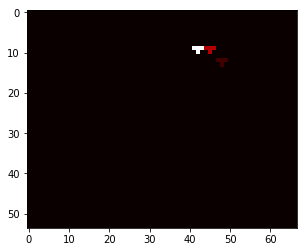

[42.    9.25]
[41.  9.]
1.0307764064044151


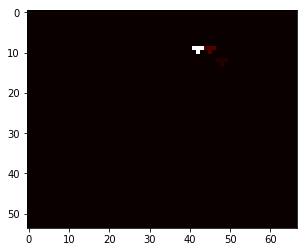

[42.    9.25]
[nan nan]
nan


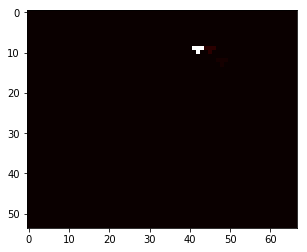

[42.    9.25]
[nan nan]
nan


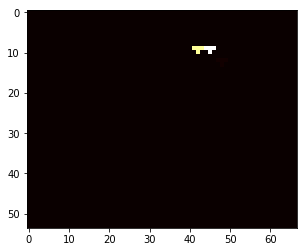

[45.    9.25]
[nan nan]
nan


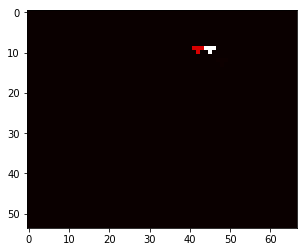

[45.    9.25]
[nan nan]
nan


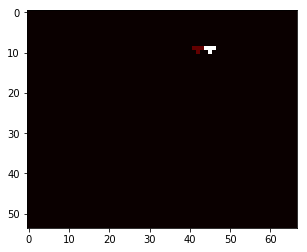

[45.    9.25]
[nan nan]
nan


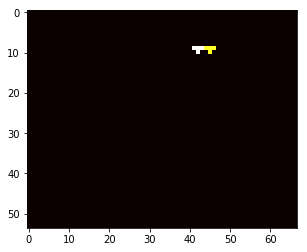

[42.    9.25]
[nan nan]
nan


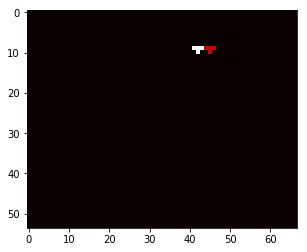

[42.    9.25]
[nan nan]
nan


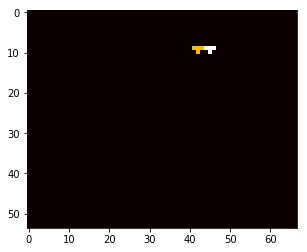

[45.    9.25]
[44.  8.]
1.6007810593582121


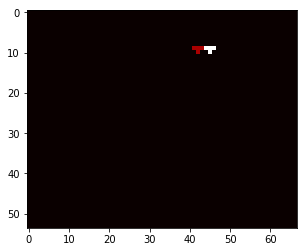

[45.    9.25]
[45.  8.]
1.25


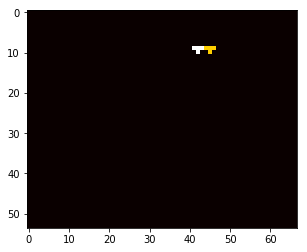

[42.    9.25]
[42.  8.]
1.25


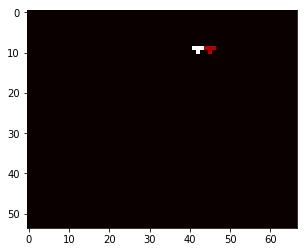

[42.    9.25]
[41.  8.]
1.6007810593582121


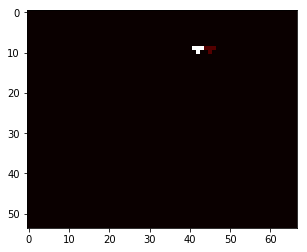

[42.    9.25]
[nan nan]
nan


In [7]:
print("please start simulation in casi now.")

In [1]:
################################################
#### AFTER SIMULATION SECTION: STORING DATA ####
################################################

# Run This after simulation has ended...

import csv

data = []
with open(groundtruth, 'r') as user_data:
    reader = csv.reader(user_data, delimiter=',', quotechar=',')
    for row in reader:
        if (reader.line_num != 1):
            # row[2] = 6.6 - float(row[2])
            row[2] = float(row[2])
            row[3] = float(row[3])
            # row[4] = 6.6 - float(row[4])
            row[4] = float(row[4])
            row[5] = float(row[5])
            data.append(row)
            
from scipy.spatial import distance

pruned_data_gt = []
pruned_data_re = []
candidate_data_gt = [data[0][4], data[0][5]]
candidate_data_re = [data[0][2], data[0][3]]
flag = 1

for i in range(len(data) - 1):
    if(flag == 1):
        pruned_data_gt.append(candidate_data_gt)
        pruned_data_re.append(candidate_data_re)
        flag = 0
    
    dist = distance.euclidean(candidate_data_gt, [data[i][4], data[i][5]])
    #print(dist)
    if(dist >= 0.5):
        flag = 1
        candidate_data_gt = [data[i][4], data[i][5]]
        candidate_data_re = [data[i][2], data[i][3]]
        
import pickle

f = open('Data_' + simworldname + '.pckl', 'wb')
pickle.dump((data, oracle, analyzer), f)
f.close()

NameError: name 'groundtruth' is not defined